In [6]:
import os
import time

import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import get_file

import tensorflow_io as tfio

from sklearn.metrics import confusion_matrix
import seaborn as sns
import scipy.signal as signal

tf.config.run_functions_eagerly(True)

In [7]:
# Load the data

os.chdir('C:\LELEC210X\LELEC210X')

"""
_ = get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)
"""

"\n_ = get_file('esc-50.zip',\n                        'https://github.com/karoldvl/ESC-50/archive/master.zip',\n                        cache_dir='./',\n                        cache_subdir='datasets',\n                        extract=True)\n"

In [8]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=10200)
    return wav

In [9]:
esc50_csv = './classification/src/classification/datasets/ESC-50/meta/esc50.csv'
base_data_path = 'classification/src/classification/datasets/ESC-50/audio'

pd_data = pd.read_csv(esc50_csv)

my_classes = ['chirping_birds', 'chainsaw', 'crackling_fire', 'helicopter', 'hand_saw']
map_class_to_id  = {label: idx for idx, label in enumerate(my_classes)}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]
unknown_pd = pd_data[~pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

unknown_pd = unknown_pd.assign(target=5)

# reduce the number of unknown samples to balance the dataset

unknown_pd = unknown_pd.sample(frac=40/1800, random_state=int(time.time()))

filtered_pd = pd.concat([filtered_pd, unknown_pd])

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

my_classes = ['chirping_birds', 'chainsaw', 'crackling_fire', 'helicopter', 'hand_saw', 'unknown']

c:\LELEC210X\LELEC210X\new_venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


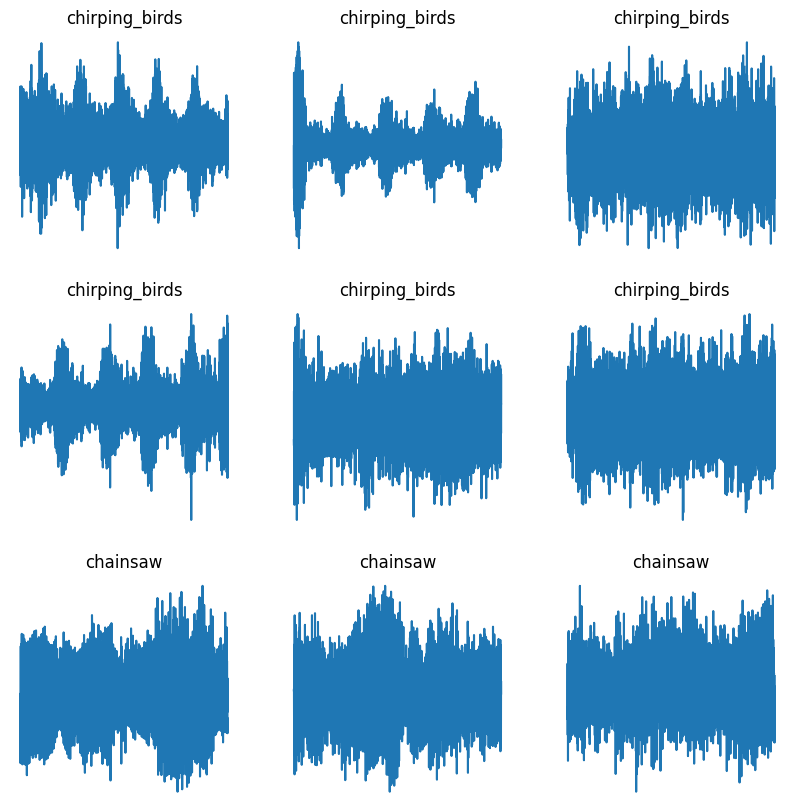

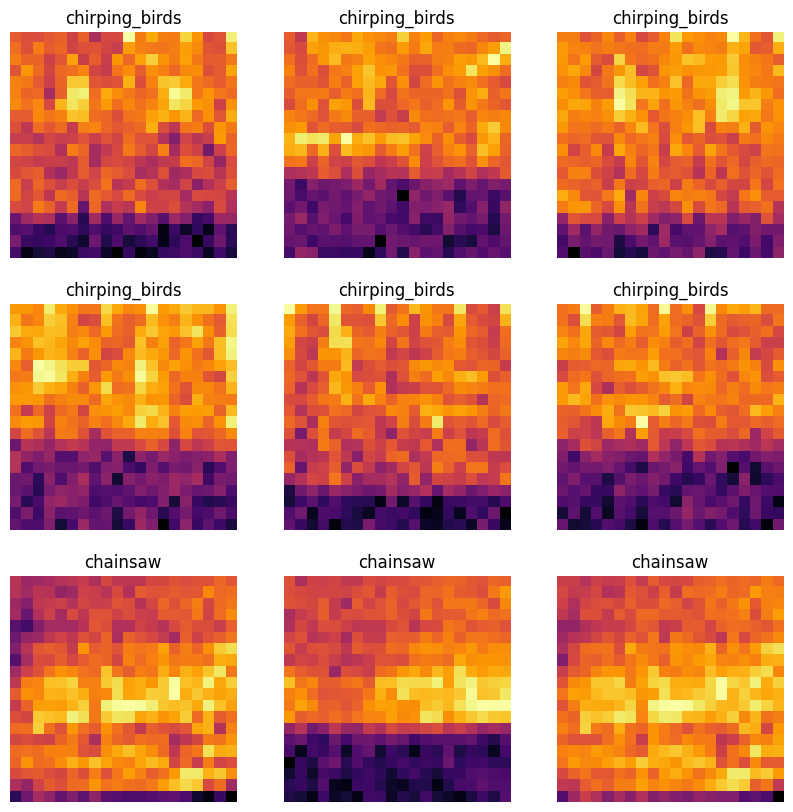

In [10]:
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

@tf.function
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)

@tf.function
def apply_time_shift(wav, label, fold):
  shift = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(wav)[0] - 8000, dtype=tf.int32)
  return wav[shift:shift+8000], label, fold

main_ds_time_shift_1 = main_ds.map(apply_time_shift)
main_ds_time_shift_2 = main_ds.map(apply_time_shift)
main_ds_time_shift_3 = main_ds.map(apply_time_shift)
main_ds_time_shift_4 = main_ds.map(apply_time_shift)

main_ds = tf.data.Dataset.zip((main_ds_time_shift_1, main_ds_time_shift_2)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))
main_ds = tf.data.Dataset.zip((main_ds, main_ds_time_shift_3)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))

@tf.function
def apply_bandpass(wav, label, fold):
  filter = signal.butter(10, [500, 5000], btype='bandpass', fs=10200, output='sos')
  wav = tf.numpy_function(lambda x: signal.sosfilt(filter, x).astype(np.float32), [wav], tf.float32)
  return wav, label, fold

main_ds_bandpass = main_ds.map(apply_bandpass)
main_ds = tf.data.Dataset.zip((main_ds, main_ds_bandpass)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))

@tf.function
def apply_noise(wav, label, fold):
  noise = tf.random.normal(tf.shape(wav), stddev=0.005)
  return wav + noise, label, fold

main_ds = main_ds.map(apply_noise)

# plot the first 9 waveforms with time shift

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (wav, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.plot(wav.numpy())
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()


# apply a melspectrogram transformation to the audio data

@tf.function
def wav2spec(wav, label, fold):
  spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=400, stride=400)
  mel_spectrogram = tfio.audio.melscale(spectrogram, rate=10200, mels=20, fmin=0, fmax=2040)
  db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
  db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, -1)  # Ensure 3 dimensions
  db_mel_spectrogram = tf.image.rot90(db_mel_spectrogram)
  return db_mel_spectrogram, label, fold

main_ds = main_ds.map(wav2spec)

# plot the first 9 spectrograms

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (spec, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.imshow(spec.numpy(), cmap='inferno')
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()

# split the dataset into training and validation sets

@tf.function
def is_validation(fold):
  return fold == 1

@tf.function
def is_test(fold):
  return fold == 2

train_ds = main_ds.filter(lambda wav, label, fold: not is_validation(fold) and not is_test(fold))
val_ds = main_ds.filter(lambda wav, label, fold: is_validation(fold))
test_ds = main_ds.filter(lambda wav, label, fold: is_test(fold))

# shuffle the training dataset

train_ds = train_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

# batch the datasets

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

# prepare the datasets for training

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)


In [11]:

# build the model

def build_model(input_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Normalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='leaky_relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(6, activation='softmax'))
  return model

input_shape = (20, 20, 1)

model = build_model(input_shape)

# compile the model

model.compile(optimizer=optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'], 
              weighted_metrics=[])

model_path = r'C:\LELEC210X\LELEC210X\classification\data\models\four.keras'

model = models.load_model(model_path)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 20, 20, 1)        3         
 ion)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 18, 18, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 9, 9, 64)          0         
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 3, 3, 128)       

Epoch 1/2
15/15 [==============================] - 17s 663ms/step - loss: 3.7714 - accuracy: 0.6133 - val_loss: 1.0928 - val_accuracy: 0.6063
Epoch 2/2
8/8 [==============================] - 10s 837ms/step - loss: 2.4507 - accuracy: 0.5430
Test accuracy: 0.54296875
1/1 [==============================] - 0s 31ms/step


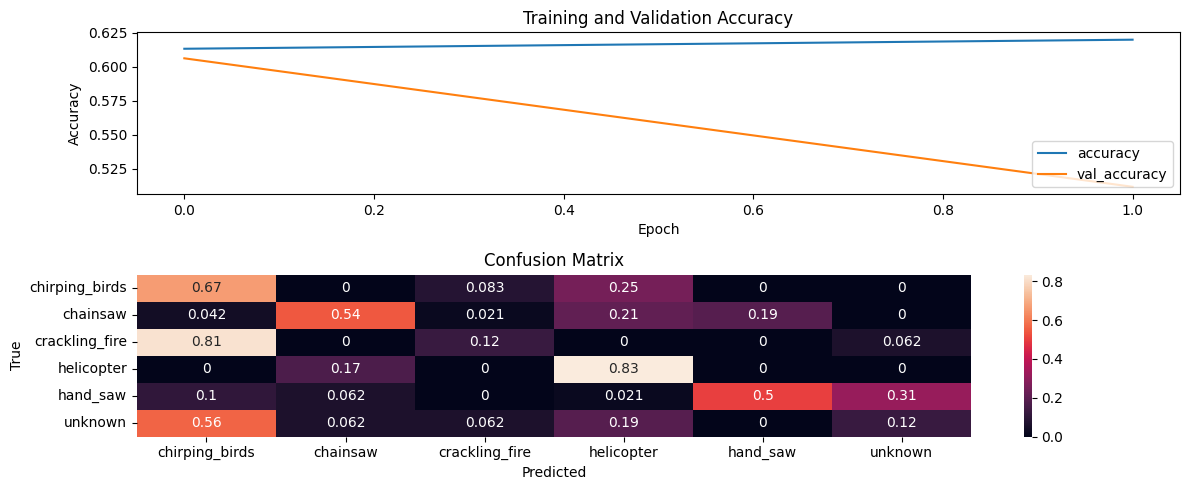

In [12]:
# train the model

history = model.fit(train_ds, validation_data=val_ds, epochs=2)

model.save(model_path)

# evaluate the model

loss, accuracy = model.evaluate(test_ds)

print(f'Test accuracy: {accuracy}')

# plot the confusion matrix

y_true = []
y_pred = []

for x, y, _ in test_ds:
  y_true.extend(y)
  y_pred.extend(model.predict(x).argmax(axis=1))
  
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# plot the training history

fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Plot the training history
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_title('Training and Validation Accuracy')

# Plot the confusion matrix
sns.heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()